# **Import Data and Functions**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import manifold, datasets
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.datasets as datasets

import os
os.chdir('/content/gdrive/MyDrive/group10')

# Load datasets
data = pd.read_csv('hfus.csv')
data1 = pd.read_csv('pKa.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Mordred Model**

In [ ]:
# Install rdkit and mordred
!pip install rdkit-pypi
!pip install mordred

from rdkit import Chem
from mordred import Calculator, descriptors

# **Use rdkit to transform SMILES**

In [ ]:
calc = Calculator(descriptors, ignore_3D = True) # calculate molecules from data

# hfus
sh = data.iloc[:,:2]
sh.columns = ['smiles','hfus']
sh = sh.astype(object)
sh['mol'] = sh['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

# pka
sp = data1.iloc[:,:2]
sp.columns = ['smiles','pka']
sp = sp.astype(object)
sp['mol'] = sp['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

sh
sp

# **Fit Mordred Model** 

In [ ]:
# hfus
sh['morrep'] = None

for i in range(sh.shape[0]):
  try:
    m = sh['mol'][i]
    sh.loc[i, 'morrep'] = calc(m)
  except:
    sh.loc[i, 'morrep'] = None
    print('skipped: {}'.format(sh['smiles'][i]))


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning:

overflow encountered in reduce



skipped: O=c1c2ccccc2cc3ccccc13


In [ ]:
# pka
sp['morrep'] = None

for i in range(sp.shape[0]):
  try:
    m = sp['mol'][i]
    sp.loc[i, 'morrep'] = calc(m)
  except:
    sp.loc[i, 'morrep'] = None
    print('skipped: {}'.format(sp['smiles'][i]))

skipped: O=c1nnnc2ccccc12


In [ ]:
# those two molecules are not chemically viable, they have carbonyl on benzen ring. 

In [ ]:
# Form Dataframe 
sh_df = pd.DataFrame(sh) #hfus
sp_df = pd.DataFrame(sp) #pka

In [ ]:
# To split the series from the morrrep model, and give each column a name from the descriptors
# hfus
sh_des = {}

for i in range(len(sh_df['morrep'])): 
  subdata = sh_df['morrep'][i]
  if subdata: # get rid of the invalid molecules
    subdata = subdata.asdict()
    for key,value in subdata.items():
      if key not in sh_des.keys():
        sh_des[key] = []
      sh_des[key].append(value)
  else:
    print('Molecule {}'.format(i), 'was skipped')


Molecule 346 was skipped


In [ ]:
# pka 
sp_des = {}

for i in range(len(sp_df['morrep'])): 
  subdata = sp_df['morrep'][i]
  if subdata: # get rid of the invalid molecules
    subdata = subdata.asdict()
    for key,value in subdata.items():
      if key not in sp_des.keys():
        sp_des[key] = []
      sp_des[key].append(value)
  else:
    print('Molecule {}'.format(i), 'was skipped')


Molecule 98 was skipped


In [ ]:
sh_des_df = pd.DataFrame(sh_des)
sp_des_df = pd.DataFrame(sp_des)

# **Mordred Representation Data Frame**

In [ ]:
#sh_des_df = pd.read_csv('mordred_hfus.csv', low_memory=False)
#sp_des_df = pd.read_csv('mordred_pka.csv', low_memory = False)

In [ ]:
# Clean up mordred representation
# hfus

sh_np = sh_des_df.to_numpy().astype("float32") # change to float 32 to prevent failure in tSNE
sh_des_df = sh_des_df.loc[:, (sh_des_df != 0).any(axis=0)] #drop zeros columns
sh_des_df = sh_des_df.loc[(sh_des_df != 0).any(axis=1)] #drop zeros rows
sh_des_df = pd.DataFrame(sh_np)
sh_des_df = sh_des_df.dropna(axis = 1) # drop nans columns
sh_des_df = sh_des_df.dropna(axis = 0) # drop nans rows
sh_des_df = sh_des_df.reset_index(drop=True)
display(sh_des_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,5.059137,5.456585,0.0,0.0,8.828427,2.000000,4.000000,8.828427,1.103553,2.888532,2.598076,0.324760,0.731628,21.904303,2.738038,2.863539,0.0,0.0,26.0,8.0,0.0,0.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,27.0,24.0,18.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.415802,6.0,3.0,1.000000,0.500000,3.807355,7.0,3.367296,4.007333,4.709530,5.370638,6.084499,6.751101,7.467942,8.135933,8.853522,69.747795,2.708050,0.0,3.761200,0.0,4.990433,0.0,6.304449,0.0,7.656810,33.420940,114.140854,4.390033,75.0,6.0,28.0,27.0,4.111111,2.166667
1,3.535534,3.869735,0.0,0.0,6.987918,1.801938,3.603875,6.987918,1.164653,2.579830,2.341896,0.390316,0.340135,12.628860,2.104810,2.025159,0.0,0.0,20.0,6.0,0.0,0.0,0.0,14.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,16.0,12.0,8.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.237222,5.0,3.0,0.666667,0.400000,3.321928,5.0,2.944439,3.496508,4.077538,4.653960,5.241747,5.826000,6.415097,7.002156,7.591357,58.248802,2.397895,0.0,3.295837,0.0,4.343805,0.0,5.459586,0.0,6.608001,28.105124,86.109550,4.305478,35.0,3.0,18.0,16.0,3.000000,1.750000
2,11.532488,9.413560,0.0,0.0,19.304037,2.275392,4.550785,19.304037,1.286936,3.626695,3.707786,0.247186,1.715900,64.900665,4.326711,4.578323,12.0,12.0,29.0,15.0,0.0,0.0,2.0,14.0,0.0,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0,172.0,208.0,176.0,124.0,...,0.024163,0.021701,0.009877,0.025625,0.0,0.458840,10.0,5.0,1.000000,0.500000,5.000000,16.0,4.317488,5.105946,5.932245,6.739336,7.564757,8.379539,9.203618,10.022026,10.845232,99.110184,3.496508,0.0,4.762174,0.0,6.216606,0.0,7.748029,0.0,9.314070,46.537384,198.115692,6.831576,404.0,18.0,74.0,82.0,4.694445,3.333333
3,5.766244,6.059284,0.0,0.0,10.383983,2.015316,4.030632,10.383983,1.153776,3.007982,2.728364,0.303152,0.898342,28.081310,3.120146,3.229744,0.0,0.0,23.0,9.0,0.0,0.0,2.0,14.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,80.0,92.0,58.0,36.0,...,0.020408,0.000000,0.000000,0.000000,0.0,0.385368,7.0,4.0,0.750000,0.428571,4.000000,8.0,3.496508,4.143135,4.844187,5.517453,6.228511,6.910751,7.624131,8.309677,9.023408,73.097763,2.833213,0.0,3.891820,0.0,5.117994,0.0,6.424869,0.0,7.773594,35.041492,130.099380,5.656495,108.0,7.0,32.0,31.0,4.361111,2.416667
4,6.473351,6.191586,0.0,0.0,11.142106,2.200122,4.400244,11.142106,1.238012,3.089776,2.850317,0.316702,0.942070,28.079758,3.119973,3.229688,6.0,6.0,21.0,9.0,0.0,0.0,0.0,12.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,80.0,89.0,60.0,18.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.438078,5.0,3.0,0.666667,0.400000,4.169925,9.0,3.713572,4.465908,5.262690,6.033086,6.834109,7.608375,8.409831,9.185125,9.986495,79.499191,2.944439,0.0,4.143135,0.0,5.556828,0.0,7.062191,0.0,8.606851,37.313446,120.093903,5.718757,88.0,9.0,40.0,43.0,3.472222,2.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,7.996954,7.498781,1.0,0.0,13.910306,1.979643,3.959286,13.910306,1.159192,3.298627,3.194136,0.266178,1.343638,47.997311,3.999776,4.053466,0.0,0.0,32.0,12.0,0.0,0.0,2.0,20.0,0.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,82.0,86.0,52.0,48.0,...,0.013605,0.012500,0.012346,0.013333,0.0,0.292203,10.0,5.0,1.000000,0.500000,4.459432,11.0,3.806663,4.442651,5.129899,5.783825,6.475433,7.136483,7.829233,8.493924,9.186970,81.285080,3.135494,0.0,4.204693,0.0,5.398163,0.0,6.647688,0.0,7.927685,39.313725,172.146332,5.379573,277.0,9.0,44.0,42.0,5.111111,3.083333
744,7.358797,6.98946

In [ ]:
# pka

sp_np = sp_des_df.to_numpy().astype("float32") # change to float 32 to prevent failure in tSNE
sp_des_df = sp_des_df.loc[:, (sp_des_df != 0).any(axis=0)] #drop zeros columns
sp_des_df = sp_des_df.loc[(sp_des_df != 0).any(axis=1)] #drop zeros rows
sp_des_df = pd.DataFrame(sp_np)
sp_des_df = sp_des_df.dropna(axis = 1) # drop nans columns
sp_des_df = sp_des_df.dropna(axis = 0) # drop nans rows
sp_des_df = sp_des_df.reset_index(drop=True)
display(sp_des_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,2.121320,2.340100,0.0,0.0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,1.946498,0.486625,-0.250259,5.891993,1.472998,0.857304,0.0,0.0,10.0,4.0,0.0,0.0,1.0,6.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.000000,22.000000,19.000000,10.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778,3.0,2.0,0.500000,0.333333,2.584963,3.0,2.397895,2.833213,3.295837,3.761200,4.234107,4.709530,5.187386,5.666427,6.146329,45.231922,1.945910,0.0,2.708050,0.0,3.610918,0.0,4.553877,0.0,5.509388,22.328144,58.041866,5.804186,10.0,1.0,10.0,8.0,2.500000,1.250000
1,6.611250,6.419894,0.0,0.0,10.891331,2.263821,4.527642,10.891331,1.210148,3.099901,2.850101,0.316678,0.941994,26.623093,2.958122,3.176419,6.0,6.0,20.0,9.0,0.0,0.0,1.0,11.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.000000,94.000000,111.000000,74.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.497685,4.0,3.0,0.333333,0.250000,4.169925,9.0,3.761200,4.553877,5.370638,6.180017,7.000334,7.812378,8.633553,9.446124,10.267470,81.025589,2.944439,0.0,4.204693,0.0,5.686975,0.0,7.263330,0.0,8.876125,37.975563,121.089149,6.054458,82.0,11.0,42.0,47.0,4.083333,2.055556
2,7.180458,6.674040,0.0,0.0,12.505532,2.202654,4.405308,12.505532,1.250553,3.188488,2.948480,0.294848,1.081290,36.641479,3.664148,3.601181,6.0,6.0,21.0,10.0,0.0,0.0,2.0,11.0,0.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.000000,116.000000,134.000000,104.000000,54.000000,...,0.040408,0.000000,0.000000,0.000000,0.000000,0.432978,7.0,4.0,0.750000,0.428571,4.321928,10.0,3.806663,4.553877,5.342334,6.115892,6.908755,7.691200,8.483637,9.269647,10.061132,82.233139,3.044523,0.0,4.234107,0.0,5.631212,0.0,7.120444,0.0,8.651899,38.682182,137.084061,6.527812,127.0,10.0,44.0,47.0,3.722222,2.416667
3,3.932653,4.244375,0.0,0.0,6.000000,2.000000,4.000000,6.000000,1.000000,2.610845,2.309401,0.384900,0.326163,11.530010,1.921668,1.934128,0.0,0.0,13.0,6.0,0.0,0.0,3.0,7.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.000000,70.000000,90.000000,26.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.548148,3.0,2.0,0.500000,0.333333,3.321928,5.0,3.135494,3.761200,4.465908,5.141664,5.837730,6.526495,7.220374,7.912423,8.605753,63.607040,2.397895,0.0,3.555348,0.0,4.875197,0.0,6.244167,0.0,7.626083,30.698690,89.047676,6.849822,29.0,4.0,22.0,21.0,4.222222,1.444444
4,10.744501,9.922672,0.0,0.0,17.936098,2.348502,4.697003,17.936098,1.195740,3.586504,3.333172,0.222211,1.609390,92.420036,6.161336,4.931809,6.0,6.0,34.0,15.0,0.0,0.0,4.0,19.0,0.0,11.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.000000,180.000000,249.000000,218.000000,161.000000,...,0.014122,0.014757,0.008230,0.010000,0.000000,0.478096,10.0,5.0,1.000000,0.500000,4.906890,15.0,4.234107,5.030438,5.872118,6.698268,7.554335,8.390041,9.251578,10.091004,10.954746,98.076637,3.433987,0.0,4.672829,0.0,6.124683,0.0,7.693937,0.0,9.326433,46.251869,209.152817,6.151553,390.0,20.0,68.0,76.0,6.194445,3.638889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,4.876566,5.209852,1.0,0.0,6.602720,2.175328,4.350656,6.602720,0.943246,2.792781,2.453689,0.350527,0.540918,14.730338,2.104334,2.333234,0.0,0.0,8.0,7.0,0.0,0.0,5.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,94.814812,69.333336,85.148148,25.666666,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.731481,3.0,2.0,0.500000,0.333333,3.584963,6.0,3.433987,4.110874,4.934474,5.666427,6.475433,7.221836,8.026497,8

In [ ]:
# check if all Nans and float are removed 
print(np.isnan(sp_des_df.to_numpy().astype("float32")).sum())
print(np.isnan(sh_des_df.to_numpy().astype("float32")).sum())

sh_des_df.columns = sh_des_df.columns.astype(str)
sp_des_df.columns = sp_des_df.columns.astype(str)

0
0


# **tSNE of Mordred Rep**

In [ ]:
# tSNE definition 

def tsneresult (dataset, perplexity):
  tsne = TSNE(n_components = 2, perplexity = perplexity, learning_rate = 'auto', init = 'random') #The result changed everytime???
  tsne_result = tsne.fit_transform(dataset)# all the descriptors? 
  print(tsne_result.shape)
  return tsne_result

def tsneresult_3d (dataset, perplexity):
  tsne = TSNE(n_components = 3, perplexity = perplexity, learning_rate = 'auto', init = 'random') #The result changed everytime???
  tsne_result = tsne.fit_transform(dataset)# all the descriptors? 
  print(tsne_result.shape)
  return tsne_result


def tsnegraph (dataset, tsne_result, perplexity, prop):
  dataset['tsne_D1'] = tsne_result[:, 0]
  dataset['tsne_D2'] = tsne_result[:, 1]
  plt.figure(figsize = (8, 5)) #16, 10
  sns.scatterplot(x = 'tsne_D1', y = 'tsne_D2', hue = prop, palette = sns.color_palette("coolwarm", as_cmap=True), data = dataset, alpha = 0.3) # how to color code
  plt.title('perplexity = {}'.format(perplexity))

def tsnegraph_3d (dataset, tsne_result, perplexity, prop):
  dataset['tsne_D1'] = tsne_result[:, 0]
  dataset['tsne_D2'] = tsne_result[:, 1]
  dataset['tsne_D3'] = tsne_result[:, 2]
  plot = px.scatter_3d(x='tsne_D1',y='tsne_D2',z='tsne_D3', data_frame = dataset, color_continuous_scale = 'Rainbow', color = prop, opacity=0.5, title = prop)
  plot.show()


# split the dataset then plot

In [ ]:
hfus_df = sh_des_df
hfus_df['hfus'] = data['Hfus']

pka_df = sp_des_df
pka_df['pka'] = data1['pka']

In [ ]:
#2D tSNE on 2D tSNE

hfus_result = tsneresult(sh_des_df, 100)
pka_result = tsneresult(sp_des_df, 100)

(748, 2)
(1632, 2)


In [ ]:
# Generate 3D parameters using tSNE
hfus_3d_result = tsneresult_3d(sh_des_df, 100)
pka_3d_result = tsneresult_3d(sp_des_df, 100)

(748, 3)
(1632, 3)


# **Visualization**

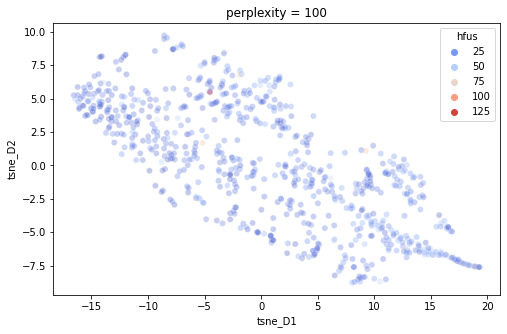

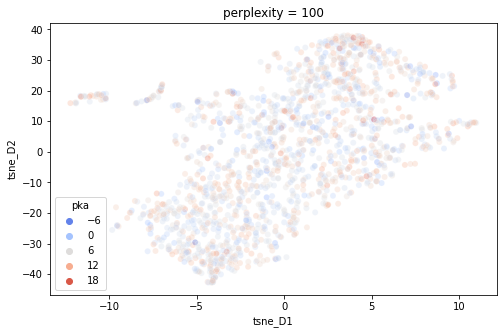

In [ ]:
#2D Visualization on mordred results
tsnegraph(hfus_df, hfus_result, 100, prop = 'hfus') # What does perplexity does
tsnegraph(pka_df, pka_result, 100, prop = 'pka')

In [ ]:
# No trends can be seen from both plots

In [ ]:
# 3D Visualization of 3D tSNE
tsnegraph_3d(hfus_df, hfus_3d_result, 100, prop = 'hfus')
tsnegraph_3d(pka_df, pka_3d_result, 100, prop = 'pka')

In [ ]:
# No trends again in the three D plot
# Colored dots seemed to be randomly scattered throughout the space. 
# Some more improvements to find trends that are not obvious include dividing the property value into smaller groups and classifying data points.

ref:
https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f

https://www.datacamp.com/community/tutorials/introduction-t-sne

# **Regression**

In [ ]:
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.datasets as datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import preprocessing

# Split Data

In [ ]:
target = sh_df['hfus']
_target = target.drop(labels=[346], axis=0) # for pka is 96
X_hfus_dev, X_hfus_test, y_hfus_dev, y_hfus_test = sklearn.model_selection.train_test_split(sh_des_df, _target, test_size = 0.1)
X_hfus_train, X_hfus_valid, y_hfus_train, y_hfus_valid = sklearn.model_selection.train_test_split(X_hfus_dev, y_hfus_dev, test_size = 0.1)

target1 = sp_df['pka']
_target1 = target1.drop(labels=[96], axis=0) # for pka is 96
X_pka_dev, X_pka_test, y_pka_dev, y_pka_test = sklearn.model_selection.train_test_split(sp_des_df, _target1, test_size = 0.1)
X_pka_train, X_pka_valid, y_pka_train, y_pka_valid = sklearn.model_selection.train_test_split(X_pka_dev, y_pka_dev, test_size = 0.1)

scaler = preprocessing.StandardScaler().fit(X_pka_train)
X_pka_train = scaler.transform(X_pka_train)

scaler1 = preprocessing.StandardScaler().fit(X_hfus_train)
X_hfus_train = scaler1.transform(X_hfus_train)

scaler2 = preprocessing.StandardScaler().fit(X_pka_valid)
X_pka_valid = scaler.transform(X_pka_valid)

scaler3 = preprocessing.StandardScaler().fit(X_hfus_valid)
X_hfus_vlid = scaler1.transform(X_hfus_valid)

scale4 = preprocessing.StandardScaler().fit(X_pka_test)
X_pka_test = scaler.transform(X_pka_test)

scaler5 = preprocessing.StandardScaler().fit(X_hfus_test)
X_hfus_test = scaler1.transform(X_hfus_test)

# Check for the percentage 
print('Mordred descriptors row: ',sh_des_df.shape[0])
print('Xh_test percentage: ', X_hfus_test.shape[0]/748)
print('Xh_train percentage: ',X_hfus_train.shape[0]/748)
print('Xh_valid percentage: ',X_hfus_valid.shape[0]/748)

print('yh_test percentage: ', y_hfus_test.shape[0]/748)
print('yh_train percentage: ',y_hfus_train.shape[0]/748)
print('yh_valid percentage: ',y_hfus_valid.shape[0]/748)

print('Mordred descriptors row: ',sp_des_df.shape[0])
print('Xp_test percentage: ', X_pka_test.shape[0]/748)
print('Xp_train percentage: ',X_pka_train.shape[0]/748)
print('Xp_valid percentage: ',X_pka_valid.shape[0]/748)

print('yp_test percentage: ', y_pka_test.shape[0]/748)
print('yp_train percentage: ',y_pka_train.shape[0]/748)
print('yp_valid percentage: ',y_pka_valid.shape[0]/748)

Mordred descriptors row:  748
Xh_test percentage:  0.10026737967914438
Xh_train percentage:  0.8088235294117647
Xh_valid percentage:  0.09090909090909091
yh_test percentage:  0.10026737967914438
yh_train percentage:  0.8088235294117647
yh_valid percentage:  0.09090909090909091
Mordred descriptors row:  1632
Xp_test percentage:  0.2192513368983957
Xp_train percentage:  1.7660427807486632
Xp_valid percentage:  0.196524064171123
yp_test percentage:  0.2192513368983957
yp_train percentage:  1.7660427807486632
yp_valid percentage:  0.196524064171123


# Linear Regression


In [ ]:
# alpha = [0.01, 0.001, 0.1, 1]
# random = [100, 400]
# l1 = [0.1, 1]
# for a in alpha:
#   for r in random:
#     for l in l1:
#       Linregr_pka = linear_model.ElasticNet(alpha=a,random_state=r,l1_ratio=l)
#       Linregr_pka.fit(X_pka_train, y_pka_train)
#       y_Linpred_valid_pka = Linregr_pka.predict(X_pka_valid)
#       print('a =', a, 'r =', r, 'l =', l, 'Coefficient of determination for validation case for pKa: {}'.format(r2_score(y_pka_valid,y_Linpred_valid_pka)))

In [ ]:
# alpha = [0.01, 0.001, 0.1, 1]
# random = [100, 400]
# l1 = [0.1, 1]
# for a in alpha:
#   for r in random:
#     for l in l1:
#       Linregr_hfus = linear_model.ElasticNet(alpha=a,random_state=r,l1_ratio=l)
#       Linregr_hfus.fit(X_hfus_train, y_hfus_train)
#       y_Linpred_valid_hfus = Linregr_hfus.predict(X_hfus_valid)
#       print('a =', a, 'r =', r, 'l =', l, 'Coefficient of determination for validation case for hfus: {}'.format(r2_score(y_hfus_valid,y_Linpred_valid_hfus)))


In [ ]:
Linregr_pka = linear_model.ElasticNet(alpha=0.01,random_state=100,l1_ratio=1)
Linregr_pka.fit(X_pka_train, y_pka_train)
Linregr_hfus = linear_model.ElasticNet(alpha=0.1,random_state=400, l1_ratio=1)
Linregr_hfus.fit(X_hfus_train, y_hfus_train)

y_Linpred_test_pka = Linregr_pka.predict(X_pka_test)
print('Coefficient of determination for test case for pKa: {}'.format(r2_score(y_pka_test,y_Linpred_test_pka)))
print('Mean sq Error for test case for pKa: {}'.format(mean_squared_error(y_pka_test,y_Linpred_test_pka)))
y_Linpred_test_hfus = Linregr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case for Heat of fusion: {}'.format(r2_score(y_hfus_test,y_Linpred_test_hfus)))
print('Mean sq Error for test case for hfus: {}'.format(mean_squared_error(y_hfus_test,y_Linpred_test_hfus)))

Coefficient of determination for test case for pKa: 0.48128309400804314
Mean sq Error for test case for pKa: 6.739541213754211
Coefficient of determination for test case for Heat of fusion: 0.8501919897909669
Mean sq Error for test case for hfus: 22.472468291909763


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e+00, tolerance: 1.636e+00



# SVR kernel linear (too long)

In [ ]:
svr_pka_linear = SVR(kernel='linear',C=1.842,epsilon=0.002)
svr_pka_linear.fit(X_pka_train, y_pka_train)

svr_hfus_linear = SVR(kernel='linear',C=1.389,epsilon=0.002)
svr_hfus_linear.fit(X_hfus_train, y_hfus_train)

SVR(C=1.389, epsilon=0.002, kernel='linear')

In [ ]:
y_pred_linear_pka_valid = svr_pka_linear.predict(X_pka_valid)
y_pred_linear_hfus_valid = svr_hfus_linear.predict(X_hfus_valid)
print('Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_linear_pka_valid)))
print('Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_linear_hfus_valid)))

Coefficient of determination for validation case: 0.23253124650053536
Coefficient of determination for validation case: -701116.1349022675


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVR was fitted without feature names



In [ ]:
y_pred_linear_pka_test = svr_pka_linear.predict(X_pka_test)
y_pred_linear_hfus_test = svr_hfus_linear.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_linear_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test, y_pred_linear_hfus_test)))

Coefficient of determination for test case: 0.2214556086050068
Coefficient of determination for test case: 0.7787338151231946


# SVR kernel poly

In [ ]:
# degree = [2, 3, 4, 5, 6]
# for d in degree:
#   svr_pka_poly = SVR(kernel='poly',degree=d)
#   svr_pka_poly.fit(X_pka_train, y_pka_train)
#   y_pred_poly_pka_valid = svr_pka_poly.predict(X_pka_valid)
#   print('d=', d, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_poly_pka_valid)))

In [ ]:
# for d in degree:
#   svr_hfus_poly = SVR(kernel='poly',degree=d)
#   svr_hfus_poly.fit(X_hfus_train, y_hfus_train)
#   y_pred_poly_hfus_valid = svr_hfus_poly.predict(X_hfus_valid)
#   print('d=', d, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_poly_hfus_valid)))

In [ ]:
svr_pka_poly = SVR(kernel='poly',degree=2)
svr_pka_poly.fit(X_pka_train, y_pka_train)
y_pred_poly_pka_test = svr_pka_poly.predict(X_pka_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_poly_pka_test)))

svr_hfus_poly = SVR(kernel='poly',degree=2)
svr_hfus_poly.fit(X_hfus_train, y_hfus_train)
y_pred_poly_hfus_test = svr_hfus_poly.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test, y_pred_poly_hfus_test)))

Coefficient of determination for test case: 0.20975421953617102
Coefficient of determination for test case: 0.7898233310851215


# SVR kernel rbf

In [ ]:
# C = [10, 30, 60, 100]
# epsilon = [0.01, 0.1, 1]
# for c in C:
#   for e in epsilon:
#     svr_pka = SVR(kernel='rbf',C=c,epsilon=e)
#     svr_pka.fit(X_pka_train, y_pka_train)
#     y_pred_rbf_pka_valid = svr_pka.predict(X_pka_valid)
#     print('C=', c, 'e =', e, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_rbf_pka_valid)))

In [ ]:
# for c in C:
#   for e in epsilon:
#     svr_hfus = SVR(kernel='rbf',C=c,epsilon=e)
#     svr_hfus.fit(X_hfus_train, y_hfus_train)
#     y_pred_rbf_hfus_valid = svr_hfus.predict(X_hfus_valid)
#     print('c=',c, 'e=', e, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_rbf_hfus_valid)))

In [ ]:
svr_pka = SVR(kernel='rbf',C=10,epsilon=0.1)
svr_pka.fit(X_pka_train, y_pka_train)

svr_hfus = SVR(kernel='rbf',C=100,epsilon=1)
svr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_rbf_pka_test = svr_pka.predict(X_pka_test)
y_pred_rbf_hfus_test = svr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_rbf_pka_test)))
print('Mean sq for test case: {}'.format(mean_squared_error(y_pka_test, y_pred_rbf_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test, y_pred_rbf_hfus_test)))

Coefficient of determination for test case: 0.522301574771905
Mean sq for test case: 6.206599760641214
Coefficient of determination for test case: 0.9259025575051496


# Decision Tree

In [ ]:
# depth = [5, 10, 15, 20]
# random = [50, 100, 200, 500]
# for d in depth:
#   for r in random:
#     dt_regr_pka = DecisionTreeRegressor(max_depth=d,criterion='squared_error',random_state=r)
#     dt_regr_pka.fit(X_pka_train, y_pka_train)
#     y_pred_dtse_pka_valid = dt_regr_pka.predict(X_pka_valid)
#     print('d=', d, 'r=', r, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_dtse_pka_valid)))

In [ ]:
# for d in depth:
#   for r in random:
#     dt_regr_hfus = DecisionTreeRegressor(max_depth=d,criterion='squared_error',random_state=r)
#     dt_regr_hfus.fit(X_hfus_train, y_hfus_train)
#     y_pred_dtse_hfus_valid = dt_regr_hfus.predict(X_hfus_valid)
#     print('d=', d, 'r=', r, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_dtse_hfus_valid)))

In [ ]:
dt_regr_pka = DecisionTreeRegressor(max_depth=5,criterion='squared_error',random_state=500)
dt_regr_hfus = DecisionTreeRegressor(max_depth=15,criterion='squared_error',random_state=100)
dt_regr_pka.fit(X_pka_train, y_pka_train)
dt_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_dtse_pka_test = dt_regr_pka.predict(X_pka_test)
y_pred_dtse_hfus_test = dt_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_dtse_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test, y_pred_dtse_hfus_test)))

Coefficient of determination for test case: 0.4313931348531309
Coefficient of determination for test case: 0.740377958603273


# Ridge Regression

In [ ]:
# alpha = [2, 4, 6, 8, 10]
# for a in alpha:
#   ridge_regr_pka = Ridge(alpha=a)
#   ridge_regr_pka.fit(X_pka_train, y_pka_train)
#   y_pred_ridreg_pka_valid = ridge_regr_pka.predict(X_pka_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_ridreg_pka_valid)))

In [ ]:
# for a in alpha:
#   ridge_regr_hfus = Ridge(alpha=a)
#   ridge_regr_hfus.fit(X_hfus_train, y_hfus_train)
#   y_pred_ridreg_hfus_valid = ridge_regr_hfus.predict(X_hfus_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_ridreg_hfus_valid)))

In [ ]:
ridge_regr_pka = Ridge(alpha=10)
ridge_regr_pka.fit(X_pka_train, y_pka_train)
ridge_regr_hfus = Ridge(alpha=10)
ridge_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_ridreg_pka_test = ridge_regr_pka.predict(X_pka_test)
y_pred_ridreg_hfus_test = ridge_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_ridreg_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_ridreg_hfus_test)))

Coefficient of determination for test case: 0.37323578067760577
Coefficient of determination for test case: 0.8342653713542002


# Kernel Ridge-linear

In [ ]:
# alpha = [1, 2, 3, 4, 5]
# for a in alpha:
#   kernelridge_linear_regr_pka = KernelRidge(alpha=a,kernel='linear')
#   kernelridge_linear_regr_pka.fit(X_pka_train, y_pka_train)
#   y_pred_kerreg_linear_pka_valid = kernelridge_linear_regr_pka.predict(X_pka_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_kerreg_linear_pka_valid)))

In [ ]:
# for a in alpha:
#   kernelridge_linear_regr_hfus = KernelRidge(alpha=a,kernel='linear')
#   kernelridge_linear_regr_hfus.fit(X_hfus_train, y_hfus_train)
#   y_pred_kerreg_linear_hfus_valid = kernelridge_linear_regr_hfus.predict(X_hfus_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_kerreg_linear_hfus_valid)))

In [ ]:
kernelridge_linear_regr_pka = KernelRidge(alpha=5,kernel='linear')
kernelridge_linear_regr_hfus = KernelRidge(alpha=5,kernel='linear')
kernelridge_linear_regr_pka.fit(X_pka_train, y_pka_train)
kernelridge_linear_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_kerreg_linear_pka_test = kernelridge_linear_regr_pka.predict(X_pka_test)
y_pred_kerreg_linear_hfus_test = kernelridge_linear_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_kerreg_linear_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_kerreg_linear_hfus_test)))

Coefficient of determination for test case: -2.4148530915989164
Coefficient of determination for test case: -0.9755035995336092


# Kernel Ridge-rbf

In [ ]:
# alpha = [0.001, 0.01, 0.1, 1, 2]

# for a in alpha:
#   kernelridge_rbf_regr_pka = KernelRidge(alpha=a,kernel='rbf')
#   kernelridge_rbf_regr_pka.fit(X_pka_train, y_pka_train)
#   y_pred_kerreg_rbf_pka_valid = kernelridge_rbf_regr_pka.predict(X_pka_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_kerreg_rbf_pka_valid)))

In [ ]:
# for a in alpha:
#   kernelridge_rbf_regr_hfus = KernelRidge(alpha=a,kernel='rbf')
#   kernelridge_rbf_regr_hfus.fit(X_hfus_train, y_hfus_train)
#   y_pred_kerreg_rbf_hfus_valid = kernelridge_rbf_regr_hfus.predict(X_hfus_valid)
#   print('a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_kerreg_rbf_hfus_valid)))

In [ ]:
kernelridge_rbf_regr_pka = KernelRidge(alpha=0.1,kernel='rbf')
kernelridge_rbf_regr_hfus = KernelRidge(alpha=0.01,kernel='rbf')
kernelridge_rbf_regr_pka.fit(X_pka_train, y_pka_train)
kernelridge_rbf_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_kerreg_rbf_pka_test = kernelridge_rbf_regr_pka.predict(X_pka_test)
y_pred_kerreg_rbf_hfus_test = kernelridge_rbf_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_kerreg_rbf_pka_test)))
print('Mean sq for test case: {}'.format(mean_squared_error(y_pka_test, y_pred_kerreg_rbf_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_kerreg_rbf_hfus_test)))

Coefficient of determination for test case: 0.45033798804907377
Mean sq for test case: 7.14160217333608
Coefficient of determination for test case: 0.8940180061948632


# Kernel Ridge-polynomial (very negative value)

In [ ]:
# for a in alpha:
#   for d in degree:
#     kernelridge_poly_regr_pka = KernelRidge(alpha=a,kernel='poly',degree=d)
#     kernelridge_poly_regr_pka.fit(X_pka_train, y_pka_train)
#     y_pred_kerreg_poly_pka_valid = kernelridge_poly_regr_pka.predict(X_pka_valid)
#     print('a=', a, 'd=', d, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_kerreg_poly_pka_valid)))

In [ ]:
# for a in alpha:
#   for d in degree:
#     kernelridge_poly_regr_hfus = KernelRidge(alpha=a,kernel='poly',degree=d)
#     kernelridge_poly_regr_hfus.fit(X_hfus_train, y_hfus_train)
#     y_pred_kerreg_poly_hfus_valid = kernelridge_poly_regr_hfus.predict(X_hfus_valid)
#     print('a=', a, 'd=', d, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_kerreg_poly_hfus_valid)))

In [ ]:
kernelridge_poly_regr_pka = KernelRidge(alpha=1,kernel='poly',degree=2)
kernelridge_poly_regr_hfus = KernelRidge(alpha=0.01,kernel='poly',degree=4)
kernelridge_poly_regr_pka.fit(X_pka_train, y_pka_train)
kernelridge_poly_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_kerreg_poly_pka_test = kernelridge_poly_regr_pka.predict(X_pka_test)
y_pred_kerreg_poly_hfus_test = kernelridge_poly_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_kerreg_poly_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_kerreg_poly_hfus_test)))

Coefficient of determination for test case: 0.48317907398072124
Coefficient of determination for test case: 0.7025430252451845


# Random forests

In [ ]:
# n = [50, 200]
# depth = [20, 30]
# random = [50, 200]
# ccp = [0.0005, 0.00005]
# for n in n:
#   for d in depth:
#     for r in random:
#       for c in ccp:
#         rf_regr_pka = RandomForestRegressor(n_estimators=n,max_depth=d, random_state=r, criterion='squared_error',ccp_alpha=c)
#         rf_regr_pka.fit(X_pka_train, y_pka_train)
#         y_pred_rf_pka_valid = rf_regr_pka.predict(X_pka_valid)
#         print('n=', n, 'd=', d, 'r=', r, 'c=', c, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_rf_pka_valid)))

In [ ]:
# n = [50, 200]
# depth = [5, 20]
# random = [50, 300]
# ccp = [0.00005]
# for n in n:
#   for d in depth:
#     for r in random:
#       for c in ccp:
#         rf_regr_hfus = RandomForestRegressor(n_estimators=n,max_depth=d, random_state=r, criterion='squared_error',ccp_alpha=c)
#         rf_regr_hfus.fit(X_hfus_train, y_hfus_train)
#         y_pred_rf_hfus_valid = rf_regr_hfus.predict(X_hfus_valid)
#         print('n=', n, 'd=', d, 'r=', r, 'c=', c, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_rf_hfus_valid)))

In [ ]:
rf_regr_pka = RandomForestRegressor(n_estimators=200,max_depth=30, random_state=50, criterion='squared_error',ccp_alpha=5e-05)
rf_regr_hfus = RandomForestRegressor(n_estimators=200,max_depth=20, random_state=300, criterion='squared_error',ccp_alpha=5e-05)
rf_regr_pka.fit(X_pka_train, y_pka_train)
rf_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_rf_pka_test = rf_regr_pka.predict(X_pka_test)
y_pred_rf_hfus_test = rf_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_rf_pka_test)))
print('Coefficient of determination for test case: {}'.format(mean_squared_error(y_pka_test, y_pred_rf_pka_test)))
print('Coefficient of determination for test case: {}'.format(mean_squared_error(y_hfus_test,y_pred_rf_hfus_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_rf_hfus_test)))

Coefficient of determination for test case: 0.6877544942738469
Coefficient of determination for test case: 4.056917039606889
Coefficient of determination for test case: 19.238817015507376
Coefficient of determination for test case: 0.8717484497728079


# kNN

In [ ]:
# neighbor = [3, 5, 7]
# pd = [1, 2, 3]

# for n in neighbor:
#   for pf in pd:
#     knn_regr_pka = KNeighborsRegressor(n_neighbors=n,weights='uniform',p=pf,metric='minkowski')
#     knn_regr_pka.fit(X_pka_train, y_pka_train)
#     y_pred_knn_pka_valid = knn_regr_pka.predict(X_pka_valid)
#     print('n=', n, 'p=', pf, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_knn_pka_valid)))

In [ ]:
# for n in neighbor:
#   for pf in pd:
#     knn_regr_hfus = KNeighborsRegressor(n_neighbors=n,weights='uniform',p=pf,metric='minkowski')
#     knn_regr_hfus.fit(X_hfus_train, y_hfus_train)
#     y_pred_knn_poly_hfus_valid = knn_regr_hfus.predict(X_hfus_valid)
#     print('n=', n, 'p=', pf, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_knn_poly_hfus_valid)))

In [ ]:
knn_regr_pka = KNeighborsRegressor(n_neighbors=7,weights='uniform',p=1,metric='minkowski')
knn_regr_hfus = KNeighborsRegressor(n_neighbors=7,weights='uniform',p=3,metric='minkowski')
knn_regr_pka.fit(X_pka_train, y_pka_train)
knn_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_knn_pka_test = knn_regr_pka.predict(X_pka_test)
y_pred_knn_hfus_test = knn_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_knn_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_knn_hfus_test)))

Coefficient of determination for test case: 0.3823184619949721
Coefficient of determination for test case: 0.8454994954489163


# Gaussian Process Regression (not used)

In [ ]:
alpha = [0.1, 1, 10]
n = [5, 10, 15]
kernel = DotProduct() + WhiteKernel()

for a in alpha:
  for n in n:
    gpr_regr_pka = GaussianProcessRegressor(kernel=kernel,random_state=200,n_restarts_optimizer=n,alpha=a)
    gpr_regr_pka.fit(X_pka_train, y_pka_train)
    y_pred_gpr_pka_valid = gpr_regr_pka.predict(X_pka_valid)
    print('n=', n,'r=', r, 'a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_gpr_pka_valid)))

NameError: ignored

In [ ]:
kernel = DotProduct() + WhiteKernel()

for a in alpha:
  for n in n:
    for r in r:
      gpr_regr_hfus = GaussianProcessRegressor(kernel=kernel,random_state=r,n_restarts_optimizer=n,alpha=a)
      gpr_regr_hfus.fit(X_hfus_train, y_hfus_train)
      y_pred_gpr_poly_hfus_valid = gpr_regr_hfus.predict(X_hfus_valid)
      print('n=', n,'r=', r, 'a=', a, 'Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_gpr_poly_hfus_valid)))

In [ ]:
kernel = DotProduct() + WhiteKernel()

gpr_regr_pka = GaussianProcessRegressor(kernel=kernel,random_state=200,n_restarts_optimizer=10,alpha=0.01)
gpr_regr_hfus = GaussianProcessRegressor(kernel=kernel,random_state=200,n_restarts_optimizer=10,alpha=0.01)
gpr_regr_pka.fit(X_pka_train, y_pka_train)
gpr_regr_hfus.fit(X_hfus_train, y_hfus_train)

y_pred_gpr_pka_test = gpr_regr_pka.predict(X_pka_test)
y_pred_gpr_hfus_test = gpr_regr_hfus.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_gpr_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_gpr_hfus_test)))

# Neural Network (not used)

In [ ]:
pka_model = Sequential()
pka_model.add(Dense(200, input_dim=424, activation='relu'))
pka_model.add(Dense(200, input_dim=200, activation='relu'))
pka_model.add(Dense(200, input_dim=200, activation='relu'))
pka_model.add(Dense(1, activation='linear'))

hfus_model = Sequential()
hfus_model.add(Dense(200, input_dim=424, activation='relu'))
hfus_model.add(Dense(200, input_dim=200, activation='relu'))
hfus_model.add(Dense(200, input_dim=200, activation='relu'))
hfus_model.add(Dense(1, activation='linear'))

In [ ]:

tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
pka_model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mean_absolute_percentage_error'])

tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
hfus_model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mean_absolute_percentage_error'])

pka_model.fit(X_pka_train, y_pka_train, epochs=50, batch_size=32,validation_split=0.15,validation_data=None,verbose=1)
hfus_model.fit(X_hfus_train, y_hfus_train, epochs=50, batch_size=32,validation_split=0.15,validation_data=None,verbose=1)

y_pred_nn_pka_valid = pka_model.predict(X_pka_valid)
y_pred_nn_poly_hfus_valid = hfus_model.predict(X_hfus_valid)
print('Coefficient of determination for validation case: {}'.format(r2_score(y_pka_valid, y_pred_nn_pka_valid)))
print('Coefficient of determination for validation case: {}'.format(r2_score(y_hfus_valid, y_pred_nn_poly_hfus_valid)))
 

In [ ]:
y_pred_nn_pka_test = pka_model.predict(X_pka_test)
y_pred_nn_hfus_test = hfus_model.predict(X_hfus_test)
print('Coefficient of determination for test case: {}'.format(r2_score(y_pka_test, y_pred_nn_pka_test)))
print('Coefficient of determination for test case: {}'.format(r2_score(y_hfus_test,y_pred_nn_hfus_test)))

In [ ]:
# SVR RBF kernel mean sq 4.2
# random forests mean sq 3.2
# (proper tuning) 
# The heat of fusion values is hard to predict according to diverge R2 value  
# not tuned correctly
# Mordred is better at characterizing molecular components and structure so that values like pKa could be determined from proton attaching or not attaching to the molecule.
# heat of fusion is largely affected by intermolecular interactions, studying a single molecular structure might not be able to capture such characteristics.
